In [1]:
from common import *
from process_ntuples import *
from process_df import *
from plotting import *
from cuts import apply_cuts, apply_pt_cut
import matplotlib.pyplot as plt
import pickle
import time

import tensorflow as tf
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

from tensorflow.keras.callbacks import EarlyStopping

#weights and biases imports
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

Welcome to JupyROOT 6.28/00


2023-04-24 00:58:43.147222: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 00:58:45.279728: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


$D^{+}$ : 411

$\Lambda_C^{+}$ : 4122

Apply Cuts Fiducial Region cuts ($𝐷^{+}$ $𝑝_T$ > 8 GeV, |𝜂| < 2.2). ***See cuts.py on how the cuts are applied***

In [2]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
Num GPUs Available:  4


In [3]:
dir_path = "/global/cfs/cdirs/atlas/gottino/Charm/Analysis/run_batch_gup/ntuples"

files = os.listdir(dir_path)

DMesonsTTree = process_ntuple(dir_path, files[0])
LambdaMesonsTTree = process_ntuple(dir_path, files[1])

branches = ["DMesons_pt", "DMesons_eta", "DMesons_m", "DMesons_fitOutput__Lxy", "DMesons_costhetastar", "DMesons_pdgId", 
            "DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId"]

print(files)

['CharmAnalysis.mc.ForcedDecay.Dplus.tree.root', 'CharmAnalysis.mc.ForcedDecay.LabmdaC.tree.root']


In [4]:
# DMesons_df = generate_df(DMesonsTTree, branches, 2000000)
# DMesons_df = apply_cuts(DMesons_df)
# DMesons_df

In [5]:
# Lambda_df = generate_df(LambdaMesonsTTree, branches, 2000000)
# Lambda_df = apply_cuts(Lambda_df)
# Lambda_df

In [8]:
DMesons_df = remove_duplicates(DMesons_df)
Lambda_df = remove_duplicates(Lambda_df)

Removed 81475 duplicate particles
Removed 34651 duplicate particles


In [9]:
save(DMesons_df, "DMesons_df")
save(Lambda_df, "Lambda_df")

In [6]:
DMesons_df = load("DMesons_df")
Lambda_df = load("Lambda_df")

In [7]:
DMesons_df = DMesons_df.head(500000)
Lambda_df = Lambda_df.head(500000)

In [8]:
#separates each particle of the event into it's own event in a new data frame (for training)
def separate(df):
    dfs = []
    for index, row in df.iterrows():

        #reco Ds
        pts = row['DMesons_pt']
        etas = row['DMesons_eta']
        ms = row['DMesons_m']
        lxys = row['DMesons_fitOutput__Lxy']
        costhetastars = row['DMesons_costhetastar']
        pdgids = row["DMesons_pdgId"]

        #reco Ds Daughter info
        daughter_pts = row["DMesons_daughterInfo__pt"]
        daughter_etas = row["DMesons_daughterInfo__eta"]
        daughter_phis = row["DMesons_daughterInfo__phi"]
        daughter_pdgIds = row["DMesons_daughterInfo__pdgId"]

        d = {df.columns[0]: pts, df.columns[1]: etas, df.columns[2]: ms, df.columns[3]: lxys, 
             df.columns[4]: costhetastars, df.columns[5]: pdgids, 

             df.columns[6]: daughter_pts, df.columns[7]: daughter_etas, df.columns[8]: daughter_phis, 
             df.columns[9]: daughter_pdgIds}
        df = pd.DataFrame(data=d)

        dfs.append(df)

    df = pd.concat(dfs)
    df = df.reset_index(drop = True)
    return df

In [10]:
# DMesons_df = separate(DMesons_df)
# Lambda_df = separate(Lambda_df)

In [4]:
# save(DMesons_df, "DMesons_df_separated")
# save(Lambda_df, "Lambda_df_separated")

DMesons_df = load("DMesons_df_separated")
Lambda_df = load("Lambda_df_separated")

In [59]:
DPlus = [-321, 211, 211]
LambdaC = [2212, -321, 211]

remove_lambda = []

count = 0
for index, row in DMesons_df.iterrows():
    if count == 50:
        break
    count+=1
    
    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    pdgids = row["DMesons_daughterInfo__pdgId"]
    
    #loop through until the first lambda encountered
    for i in range(len(pdgids) - 1):
        #if there are multiple lambda baryons
        if len(pdgids) > 2:
            #stop at the first lambda and keep the higher proton pt valued lambda
            if list(pdgids[i]) == LambdaC:
                l1_pt, l2_pt = pts[i][0], pts[i + 1][0]
                if (l1_pt > l2_pt):
                    #Lambda 1's proton has higher pt
                    remove_lambda.append((index, i + 1))
                elif (l1_pt < l2_pt):
                    #Lambda 2's proton has higher pt!
                    remove_lambda.append((index, i))
                else:
                    raise Exception("Error: Are the proton pt vaules equal?")
                    
len(remove_lambda)

3

In [24]:
#takes tuples of shape (2,) / (index, column)
def remove_particles_from_df(df, tuple_list):
    for tup in tuple_list:
        index, column = tup
        print(index, column)
        
        new_df = df.copy()
        for i in range(len(DMesons_df.iloc[index, 0][column]) + 1):
            #new_df["DMesons_daughterInfo__pt"] = new_df["DMesons_daughterInfo__pt"].apply(lambda x: print(x))
            val = new_df.iloc[index, i][column]
            print(val)
    df = df.drop(index, axis = 0)
    return df
#df = remove_particles_from_df(DMesons_df, remove_lambda)

pd.set_option('display.max_rows', 10)

In [11]:
def count(df):
    D = 0
    Lambda = 0
    for pdgId in df["DMesons_pdgId"]:
        if pdgId == 411 or pdgId == 0:
            D+=1
        elif pdgId == 4122 or pdgId == 1:
            Lambda+=1
    return D, Lambda

count(DMesons_df)

(6280052, 6017574)

In [17]:
def func(x):
    if x == 411:
        return 'only_411'
    elif x == 4122:
        return 'only_4122'
    else:
        return "both"

DMesons_df['particle_type'] = DMesons_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = DMesons_df[DMesons_df['particle_type'] == 'only_411']
only_4122 = DMesons_df[DMesons_df['particle_type'] == 'only_4122']
#both = DMesons_df[DMesons_df['particle_type'] == 'both']

new_df = DMesons_df[DMesons_df['particle_type'] != 'both']
new_df = new_df.reset_index(drop=True)

new_df = new_df.drop('particle_type', axis=1)

In [18]:
save(only_4122, "DMesons_only_4122")

In [13]:
# create a new column 'particle_type' based on the pdgId column

def func(x):
    if x == 411:
        return 'only_411'
    elif x == 4122:
        return 'only_4122'
    else:
        return "both"

Lambda_df['particle_type'] = Lambda_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = Lambda_df[Lambda_df['particle_type'] == 'only_411']
only_4122 = Lambda_df[Lambda_df['particle_type'] == 'only_4122']
#both = DMesons_df[DMesons_df['particle_type'] == 'both']

new_df = Lambda_df[Lambda_df['particle_type'] != 'both']
new_df = new_df.reset_index(drop=True)

new_df = new_df.drop('particle_type', axis=1)

In [16]:
save(only_4122, "Lambda_only_4122")

In [11]:
# Read
Lambda_only_4122 = load("Lambda_only_4122")
DMesons_only_4122 = load("DMesons_only_4122")

In [12]:
DMesons_only_4122['DMesons_pdgId'] = DMesons_only_4122['DMesons_pdgId'].replace({4122: 411})

DMesons_only_4122

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,particle_type
2,18.993742,-1.661963,2398.886963,1.918414,-0.065073,411,"[6.605627059936523, 6.457057952880859, 5.96782...","(-1.7326077, -1.608788, -1.6305238)","(-0.49662885, -0.371787, -0.5161313)","(2212, -321, 211)",only_4122
4,10.118494,0.041659,2468.180664,2.890126,0.427697,411,"[3.3083105087280273, 3.7944977283477783, 3.065...","(0.22605924, -0.073717244, -0.017923404)","(0.6827104, 0.753864, 0.920779)","(2212, -321, 211)",only_4122
6,12.579471,-1.102560,2220.384521,0.924919,-0.413329,411,"[7.396467208862305, 3.7815563678741455, 1.4123...","(-1.182188, -0.9284433, -1.1012387)","(0.7419038, 0.8518817, 0.77916163)","(2212, -321, 211)",only_4122
7,36.128836,0.659816,2235.698730,0.358412,0.190362,411,"[18.936317443847656, 15.39889907836914, 1.8038...","(0.69086045, 0.62282157, 0.63955635)","(0.857847, 0.81737196, 0.7582323)","(2212, -321, 211)",only_4122
9,15.020291,-0.034316,2239.309326,1.028398,0.067321,411,"[8.733827590942383, 4.532932281494141, 1.78765...","(0.01380682, -0.04224944, -0.24547637)","(2.2951803, 2.1494887, 2.202617)","(2212, -321, 211)",only_4122
...,...,...,...,...,...,...,...,...,...,...,...
829417,18.804258,0.885162,2189.650146,7.739953,-0.889773,411,"[12.417222023010254, 2.854801654815674, 3.5459...","(0.9136081, 0.91393214, 0.7531416)","(1.6027179, 1.6470815, 1.6886618)","(2212, -321, 211)",only_4122
829419,17.901893,-0.774406,2254.505371,5.573455,0.345450,411,"[10.548990249633789, 4.042133808135986, 3.3070...","(-0.71441394, -0.78476083, -0.939658)","(1.8309624, 1.8176006, 1.7980983)","(2212, -321, 211)",only_4122
829421,13.787465,0.994835,2403.642334,9.813573,0.585470,411,"[5.433959007263184, 5.768528938293457, 2.64782...","(0.9409741, 0.9637201, 1.1431166)","(1.0212605, 0.8464486, 0.807192)","(2212, -321, 211)",only_4122
829423,21.512328,-0.477626,2418.774170,1.613223,0.734164,411,"[8.097429275512695, 9.11487102508545, 4.309597...","(-0.40710476, -0.47758043, -0.60352147)","(0.27852488, 0.3333423, 0.26191172)","(2212, -321, 211)",only_4122


In [13]:
# Lambda_only_4122 = Lambda_only_4122.head(400000)
# DMesons_only_411 = DMesons_only_411.head(400000)

combined_df = pd.concat([Lambda_only_4122, DMesons_only_4122], axis=0)

# Shuffle the rows of the combined data frame
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)

In [14]:
shuffled_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,particle_type
0,14.495960,2.068161,2269.677734,0.426400,0.224030,4122,"[4.866639137268066, 6.233001232147217, 3.47417...","(2.0698483, 2.0432634, 2.092864)","(1.9282836, 1.7965089, 2.0228438)","(2212, -321, 211)",only_4122
1,18.392408,0.198644,2284.827148,0.858600,0.781461,4122,"[4.016572952270508, 9.644989013671875, 4.74016...","(0.18772173, 0.23252325, 0.13839939)","(-3.0759099, -3.023404, -3.035216)","(2212, -321, 211)",only_4122
2,41.166922,0.868607,2296.675781,0.059236,0.323120,4122,"[19.729450225830078, 19.46175193786621, 1.9885...","(0.83127713, 0.9002127, 0.9180538)","(0.3816241, 0.3565681, 0.40370935)","(2212, -321, 211)",only_4122
3,19.850971,-0.014880,2269.079834,0.658014,-0.368115,4122,"[14.824045181274414, 4.195254325866699, 0.8567...","(0.010287268, -0.052050386, -0.26542997)","(1.8478316, 1.7669779, 2.0197604)","(2212, -321, 211)",only_4122
4,12.071737,0.849297,2289.308105,0.051149,0.822036,4122,"[6.8638224601745605, 4.265861511230469, 1.0305...","(0.792443, 0.88804525, 0.9915146)","(-0.8532753, -0.8090768, -0.40661362)","(2212, -321, 211)",only_4122
...,...,...,...,...,...,...,...,...,...,...,...
999808,37.423441,-1.755403,2103.914551,3.889393,-0.270817,411,"[25.422626495361328, 10.21939468383789, 1.7935...","(-1.7678546, -1.7212219, -1.7604791)","(2.118341, 2.0711646, 2.0092993)","(2212, -321, 211)",only_4122
999809,24.682957,1.321535,2430.404297,0.469334,-0.183932,411,"[8.431061744689941, 6.834738731384277, 9.43543...","(1.3345634, 1.3238475, 1.3034419)","(-1.4396629, -1.2819511, -1.3711286)","(2212, -321, 211)",only_4122
999810,51.712094,0.617304,2207.007080,10.334098,-0.728289,411,"[30.39325523376465, 8.018707275390625, 13.2916...","(0.6144363, 0.6319005, 0.61490214)","(0.059602182, 0.112402424, 0.108593486)","(2212, -321, 211)",only_4122
999811,27.987713,0.353341,2286.011230,0.589687,-0.963699,4122,"[18.832998275756836, 2.31501841545105, 6.85884...","(0.35977262, 0.31118584, 0.34897467)","(0.7476053, 0.8326355, 0.80383223)","(2212, -321, 211)",only_4122


In [15]:
shuffled_df_daughter = shuffled_df[["DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"]]

In [13]:
#separate the daughter info
daughter_pts = []
daughter_etas = []
daughter_phis = []

for index, row in shuffled_df_daughter.iterrows():

    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    
    for pt, eta, phi in zip(pts, etas, phis):
        daughter_pts.append(pt)
        daughter_etas.append(etas)
        daughter_phis.append(phis)

In [14]:
particle1_pt = []
particle2_pt = []
particle3_pt = []

for i in range(0, len(daughter_pts), 3):
    particle1_pt.append(daughter_pts[i])
    particle2_pt.append(daughter_pts[i+1])
    particle3_pt.append(daughter_pts[i+2])

In [134]:
k_mass = 0.493677 #Gev/c^2
pi_mass = 0.13957 #Gev/c^2
p_mass = 0.938 #Gev/c^2

def createTLorentzVectors(df):
    TLorentzVectorList = []
    
    for index, row in df.iterrows():
        pts = row['DMesons_daughterInfo__pt']
        etas = row['DMesons_daughterInfo__eta']
        phis = row['DMesons_daughterInfo__phi']
        pdgids = row['DMesons_daughterInfo__pdgId']
        types = row["particle_type"]
        
        def assign_mass():
            if types == "only_411" or "only_4122":
                #assume proton is pion
                return p_mass
            elif types == "only_4122":
                #keep proton as proton
                return p_mass
            else:
                return pi_mass
            
        for pt, eta, phi, pdgid in zip(pts, etas, phis, pdgids):
            if pdgid == 211:
                m = pi_mass
            elif pdgid == -321:
                m = k_mass
            elif pdgid == 2212:
                m = assign_mass()
            else:
                continue

            p = ROOT.TLorentzVector()
            p.SetPtEtaPhiM(pt, eta, phi, m)
            TLorentzVectorList.append(p)

    return TLorentzVectorList

inv_mass_squared = lambda p1, p2: (p1 + p2).M2()

In [135]:
LorentzVectors = createTLorentzVectors(shuffled_df_daughter)
reshaped_list = [LorentzVectors[i:i+3] for i in range(0, len(LorentzVectors), 3)]
np.shape(reshaped_list)

(999813, 3)

In [137]:
pk_list = []
kpi_list = []

#find the ordering of the Loretnz Vectors

#Lambda Hypothesis
p_LorentzVectors = []
k_LorentzVectors = []
pi_LorentzVectors = []
for i in LorentzVectors:
    if round(i.M(), 3) == p_mass:
        p_LorentzVectors.append(i)
    elif round(i.M(), 6) == k_mass:
        k_LorentzVectors.append(i)
    elif round(i.M(), 4) == 0.1396:
        pi_LorentzVectors.append(i)
        
for i in range(len(p_LorentzVectors)):
    pk = inv_mass_squared(p_LorentzVectors[i], k_LorentzVectors[i])
    kpi = inv_mass_squared(k_LorentzVectors[i], pi_LorentzVectors[i])
    pk_list.append(pk)
    kpi_list.append(kpi)


#D+ Hypothesis
# p_LorentzVectors = []
# k_LorentzVectors = []
# pi_LorentzVectors = []
# for sublist in reshaped_list:
#     for i in range(len(sublist)):
#         if round(sublist[i].M(), 4) == 0.1396 and i == 0:
#             p_LorentzVectors.append(sublist[0])
#         elif round(sublist[i].M(), 4) == 0.4937:
#             k_LorentzVectors.append(sublist[1])
#         elif round(sublist[i].M(), 4) == 0.1396 and i == 2:
#             pi_LorentzVectors.append(sublist[2])

In [140]:
len(p_LorentzVectors)

999813

In [108]:
# for i in range(len(p_LorentzVectors)):
#     pk = inv_mass_squared(p_LorentzVectors[i], k_LorentzVectors[i])
#     kpi = inv_mass_squared(k_LorentzVectors[i], pi_LorentzVectors[i])
#     pk_list.append(pk)
#     kpi_list.append(kpi)

In [138]:
#D+ hypothesis
#inv_mass1 is pk assuming proton is pion for all candidates
#inv_mass2 is kpi
shuffled_df['inv_mass3'] = pk_list
shuffled_df['inv_mass4'] = kpi_list

In [141]:
invmass_ready_df = shuffled_df.drop(['DMesons_daughterInfo__pt', 'DMesons_daughterInfo__eta', "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"], axis=1)
# invmass_ready_df["daughter_pt1"] = particle1_pt
# invmass_ready_df["daughter_pt2"] = particle2_pt
# invmass_ready_df["daughter_pt3"] = particle3_pt
invmass_ready_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,inv_mass1,inv_mass2,inv_mass3,inv_mass4
0,14.495960,2.068161,2269.677734,0.426400,0.224030,4122,1.030158,1.596893,2.964043,1.596893
1,18.392408,0.198644,2284.827148,0.858600,0.781461,4122,0.595496,0.832936,3.516314,0.832936
2,41.166922,0.868607,2296.675781,0.059236,0.323120,4122,2.585226,0.574857,4.336044,0.574857
3,19.850971,-0.014880,2269.079834,0.658014,-0.368115,4122,1.773955,0.799523,2.879549,0.799523
4,12.071737,0.849297,2289.308105,0.051149,0.822036,4122,0.967829,1.151076,2.399489,1.151076
...,...,...,...,...,...,...,...,...,...,...
999808,37.423441,-1.755403,2103.914551,3.889393,-0.270817,411,2.047315,0.512923,3.238719,0.512923
999809,24.682957,1.321535,2430.404297,0.469334,-0.183932,411,2.019141,1.147396,3.570420,1.147396
999810,51.712094,0.617304,2207.007080,10.334098,-0.728289,411,1.936293,0.707354,3.026112,0.707354
999811,27.987713,0.353341,2286.011230,0.589687,-0.963699,4122,2.677253,1.029093,3.643798,1.029093


In [142]:
# create a new column 'particle_type' based on the pdgId column
def func(x):
    if x == 0 or x == 411:
        return 'only_411'
    elif x == 1 or x == 4122:
        return 'only_4122'

invmass_ready_df['particle_type'] = invmass_ready_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_411']
only_4122 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_4122']

new_df = invmass_ready_df[invmass_ready_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)
# only_411 = only_411.reset_index(drop=True)
# only_4122 = only_4122.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [143]:
only_411 = only_411.drop('particle_type', axis=1)
only_4122 = only_4122.drop('particle_type', axis=1)
new_df = new_df.drop("particle_type", axis=1)

new_df = new_df.drop('DMesons_m', axis=1)
only_411 = only_411.drop('DMesons_m', axis=1)
only_4122 = only_4122.drop('DMesons_m', axis=1)

In [144]:
new_df

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,inv_mass1,inv_mass2,inv_mass3,inv_mass4
0,14.495960,2.068161,0.426400,0.224030,4122,1.030158,1.596893,2.964043,1.596893
1,18.392408,0.198644,0.858600,0.781461,4122,0.595496,0.832936,3.516314,0.832936
2,41.166922,0.868607,0.059236,0.323120,4122,2.585226,0.574857,4.336044,0.574857
3,19.850971,-0.014880,0.658014,-0.368115,4122,1.773955,0.799523,2.879549,0.799523
4,12.071737,0.849297,0.051149,0.822036,4122,0.967829,1.151076,2.399489,1.151076
...,...,...,...,...,...,...,...,...,...
999808,37.423441,-1.755403,3.889393,-0.270817,411,2.047315,0.512923,3.238719,0.512923
999809,24.682957,1.321535,0.469334,-0.183932,411,2.019141,1.147396,3.570420,1.147396
999810,51.712094,0.617304,10.334098,-0.728289,411,1.936293,0.707354,3.026112,0.707354
999811,27.987713,0.353341,0.589687,-0.963699,4122,2.677253,1.029093,3.643798,1.029093


In [23]:
save(new_df, "new_df_invmassdaughter_train")
save(only_411, "only_411_invmassdaughter_train")
save(only_4122, "only_4122_invmassdaughter_train")

In [2]:
new_df = load("new_df_invmassdaughter_train")
only_411 = load("only_411_invmassdaughter_train")
only_4122 = load("only_4122_invmassdaughter_train")

In [151]:
training_columns = ['DMesons_pt','DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar', "inv_mass1", "inv_mass2", "inv_mass3", "inv_mass4"]
#D and Lambda
new_df['DMesons_pdgId'] = new_df['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train, X_test, y_train, y_test = train_test_split(new_df[training_columns], new_df['DMesons_pdgId'], test_size=0.2, random_state=42)

#only DMesons
only_411['DMesons_pdgId'] = only_411['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train1, X_test1, y_train1, y_test1 = train_test_split(only_411[training_columns], only_411['DMesons_pdgId'], test_size=0.2, random_state=42)

#only Lambda
only_4122['DMesons_pdgId'] = only_4122['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train2, X_test2, y_train2, y_test2 = train_test_split(only_4122[training_columns], only_4122['DMesons_pdgId'], test_size=0.2, random_state=42)

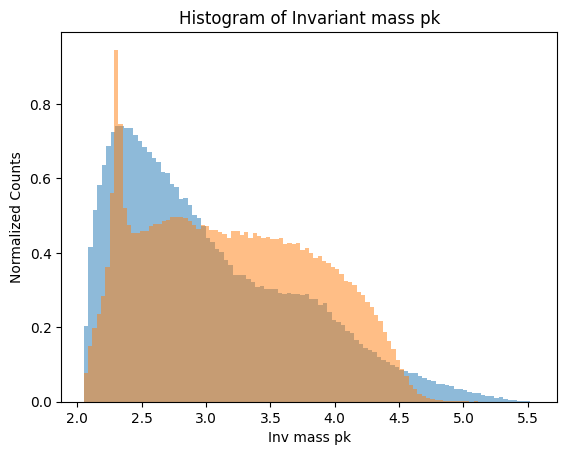

In [154]:
counts, bins, _ = plt.hist(X_train1["inv_mass3"], bins=100)
counts2, bins2, _ = plt.hist(X_train2["inv_mass3"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Histogram of Invariant mass pk")
plt.xlabel("Inv mass pk")
plt.ylabel("Normalized Counts")
plt.show()

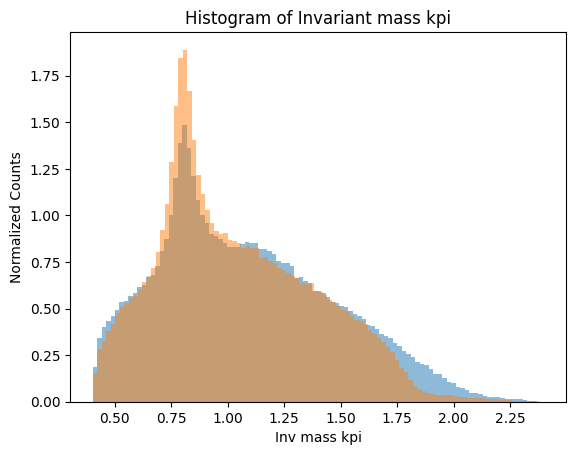

In [156]:
counts, bins, _ = plt.hist(X_train1["inv_mass4"], bins=100)
counts2, bins2, _ = plt.hist(X_train2["inv_mass4"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Histogram of Invariant mass kpi")
plt.xlabel("Inv mass kpi")
plt.ylabel("Normalized Counts")
plt.show()

In [157]:
print(np.shape(X_train), np.shape(X_test))

X_train

(799850, 8) (199963, 8)


,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,inv_mass1,inv_mass2,inv_mass3,inv_mass4
383236,23.735781,0.359814,0.774353,-0.910236,0.951464,1.475489,2.171495,1.475489
834424,35.018375,-1.202599,0.912337,0.149689,2.990054,0.619943,4.646428,0.619943
113430,18.321869,0.142560,4.876323,-0.232766,1.632243,1.387267,3.021853,1.387267
149052,25.228852,0.561592,0.132659,0.690220,1.119403,0.717390,3.365021,0.717390
854671,17.077115,-0.602918,0.605038,-0.770535,2.844860,1.057883,3.893604,1.057883
...,...,...,...,...,...,...,...,...
259178,22.760107,0.009891,0.749921,-0.560139,2.883267,1.044056,4.048598,1.044056
365838,16.324172,-1.421487,1.207509,-0.952762,1.112715,1.236718,2.282373,1.236718
131932,22.940553,-0.650408,0.578850,-0.625472,1.510176,0.969398,2.699565,0.969398
671155,11.430139,0.938404,0.475203,0.467138,1.503118,1.490372,3.467746,1.490372


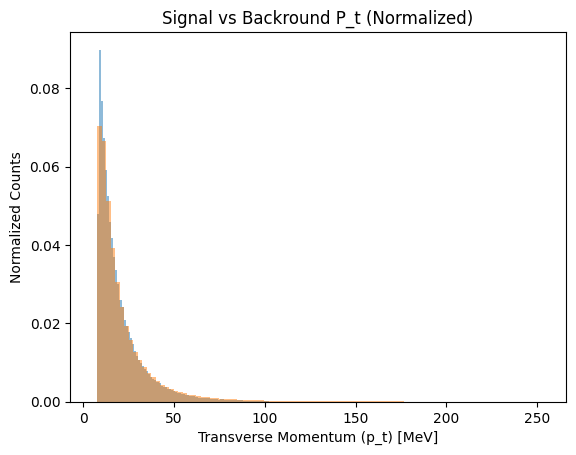

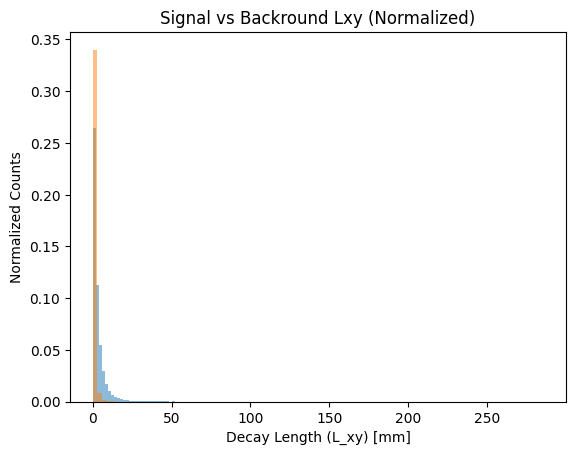

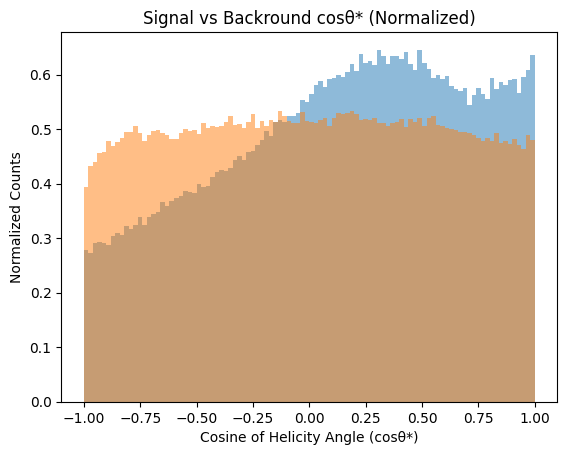

In [158]:
counts, bins, _ = plt.hist(X_train1["DMesons_pt"], bins=100)
counts2, bins2, _ = plt.hist(X_train2["DMesons_pt"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Signal vs Backround P_t (Normalized)")
plt.xlabel("Transverse Momentum (p_t) [MeV]")
plt.ylabel("Normalized Counts")
plt.show()

counts, bins, _ = plt.hist(X_train1["DMesons_fitOutput__Lxy"], bins=100)
counts2, bins2, _ = plt.hist(X_train2["DMesons_fitOutput__Lxy"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Signal vs Backround Lxy (Normalized)")
plt.xlabel("Decay Length (L_xy) [mm]")
plt.ylabel("Normalized Counts")
plt.show()

counts, bins, _ = plt.hist(X_train1["DMesons_costhetastar"], bins=100)
counts2, bins2, _ = plt.hist(X_train2["DMesons_costhetastar"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Signal vs Backround cosθ* (Normalized)")
plt.xlabel("Cosine of Helicity Angle (cosθ*)")
plt.ylabel("Normalized Counts")
plt.show()

In [45]:
# counts, bins, _ = plt.hist(X_train1["daughter_pt1"], bins=100)
# counts2, bins2, _ = plt.hist(X_train2["daughter_pt1"], bins=100)
# # Normalize the histogram using the formula
# density = counts / (sum(counts) * np.diff(bins))
# density2 = counts2 / (sum(counts2) * np.diff(bins2))

# # Plot the normalized histogram
# plt.clf()
# plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
# plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
# plt.title("Signal vs Backround Daughter P_t (Normalized)")
# plt.xlabel("Transverse Momentum (p_t) [MeV]")
# plt.ylabel("Normalized Counts")
# plt.show()

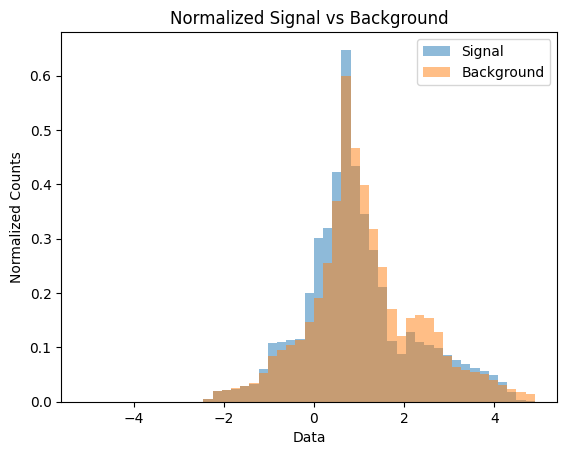

In [159]:
#counts, bins, _ = plt.hist(X_train1, bins=20)
bins = np.linspace(-5, 5, 50)
signal_counts, _ = np.histogram(X_train2, bins=bins, density=True)
background_counts, _ = np.histogram(X_train1, bins=bins, density=True)

# Plot the signal and background histograms on the same plot
plt.bar(bins[:-1], signal_counts, width=np.diff(bins), alpha=0.5, label='Signal')
plt.bar(bins[:-1], background_counts, width=np.diff(bins), alpha=0.5, label='Background')

# Add axis labels and a legend
plt.xlabel('Data')
plt.ylabel('Normalized Counts')
plt.title("Normalized Signal vs Background")
plt.legend()

# Show the plot
plt.show()

In [160]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ATLAS_DNN",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 64,
        "activation_1": "relu",
        "dropout_1": 0.5,
        "layer_2": 32,
        "activation_2": "relu",
        "dropout_2": 0.5,
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 25,
        "batch_size": 32
    }
)
config = wandb.config

In [161]:
# def get_config(self):
#     return config

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        self.dropout1 = Dropout(config.dropout_1)
        
        self.dense2 = Dense(config.layer_2, activation = config.activation_2)
        self.dropout2 = Dropout(config.dropout_2)
        
        self.dense3 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        x = self.dropout2(x)
        
        x = self.dense3(x)
        
        return x
    
model = MyModel()
model.build(input_shape=(None, X_train.shape[1]))
model.summary()

def custom_accuracy(y_true, y_pred): 
    
    y_pred_binary = tf.cast(tf.round(y_pred), tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    
    correct_predictions = tf.equal(y_true, y_pred_binary)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    return accuracy

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             multiple                  576       
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dense_4 (Dense)             multiple                  2080      
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dense_5 (Dense)             multiple                  33        
                                                                 
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
_________________________________________________________________


In [162]:
#Compile
start_time = time.time()

model.compile(optimizer=config.optimizer, loss=config.loss, metrics=[custom_accuracy])

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
#Train
with tf.device('/gpu:0'):
    history = model.fit(X_train, y_train, epochs=config.epoch, batch_size=config.batch_size, validation_data=(X_test, y_test), callbacks=[early_stop, WandbCallback(), tf.keras.callbacks.History()])

#Evaluate testing set
loss = model.evaluate(X_test, y_test)
print("Loss: {}".format(loss))

end_time = time.time()
runtime = end_time - start_time
print("Training runtime:", runtime, "seconds")

Epoch 1/25
24970/24996 [============================>.] - ETA: 0s - loss: 0.4371 - custom_accuracy: 0.8082

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 46s 2ms/step - loss: 0.4371 - custom_accuracy: 0.8082 - val_loss: 0.3893 - val_custom_accuracy: 0.8262
Epoch 2/25
24989/24996 [============================>.] - ETA: 0s - loss: 0.4077 - custom_accuracy: 0.8186

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 45s 2ms/step - loss: 0.4077 - custom_accuracy: 0.8186 - val_loss: 0.3777 - val_custom_accuracy: 0.8287
Epoch 3/25
24989/24996 [============================>.] - ETA: 0s - loss: 0.4032 - custom_accuracy: 0.8204

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 44s 2ms/step - loss: 0.4031 - custom_accuracy: 0.8204 - val_loss: 0.3729 - val_custom_accuracy: 0.8308
Epoch 4/25
24996/24996 [==============================] - 44s 2ms/step - loss: 0.4005 - custom_accuracy: 0.8227 - val_loss: 0.3742 - val_custom_accuracy: 0.8368
Epoch 5/25
24965/24996 [============================>.] - ETA: 0s - loss: 0.3968 - custom_accuracy: 0.8248

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 44s 2ms/step - loss: 0.3968 - custom_accuracy: 0.8248 - val_loss: 0.3669 - val_custom_accuracy: 0.8393
Epoch 6/25
24970/24996 [============================>.] - ETA: 0s - loss: 0.3944 - custom_accuracy: 0.8255

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 44s 2ms/step - loss: 0.3945 - custom_accuracy: 0.8255 - val_loss: 0.3639 - val_custom_accuracy: 0.8396
Epoch 7/25
24980/24996 [============================>.] - ETA: 0s - loss: 0.3940 - custom_accuracy: 0.8265

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 44s 2ms/step - loss: 0.3941 - custom_accuracy: 0.8265 - val_loss: 0.3608 - val_custom_accuracy: 0.8416
Epoch 8/25
24996/24996 [==============================] - 44s 2ms/step - loss: 0.3921 - custom_accuracy: 0.8276 - val_loss: 0.3640 - val_custom_accuracy: 0.8405
Epoch 9/25
24996/24996 [==============================] - 44s 2ms/step - loss: 0.3916 - custom_accuracy: 0.8275 - val_loss: 0.3657 - val_custom_accuracy: 0.8378
Epoch 10/25
24965/24996 [============================>.] - ETA: 0s - loss: 0.3907 - custom_accuracy: 0.8278

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 44s 2ms/step - loss: 0.3907 - custom_accuracy: 0.8278 - val_loss: 0.3594 - val_custom_accuracy: 0.8415
Epoch 11/25
24996/24996 [==============================] - 44s 2ms/step - loss: 0.3899 - custom_accuracy: 0.8283 - val_loss: 0.3613 - val_custom_accuracy: 0.8425
Epoch 12/25
24986/24996 [============================>.] - ETA: 0s - loss: 0.3897 - custom_accuracy: 0.8290

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 45s 2ms/step - loss: 0.3896 - custom_accuracy: 0.8290 - val_loss: 0.3579 - val_custom_accuracy: 0.8431
Epoch 13/25
24996/24996 [==============================] - ETA: 0s - loss: 0.3889 - custom_accuracy: 0.8293

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230424_042735-9p1j0cn8/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 44s 2ms/step - loss: 0.3889 - custom_accuracy: 0.8293 - val_loss: 0.3552 - val_custom_accuracy: 0.8444
Epoch 14/25
24996/24996 [==============================] - 44s 2ms/step - loss: 0.3882 - custom_accuracy: 0.8298 - val_loss: 0.3635 - val_custom_accuracy: 0.8364
Epoch 15/25
 4945/24996 [====>.........................] - ETA: 31s - loss: 0.3852 - custom_accuracy: 0.8303

KeyboardInterrupt: 

2023-04-24 04:28:26.772826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-24 04:28:26.782036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-24 04:28:26.884273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-24 04:28:26

In [163]:
wandb.finish()

custom_accuracy,▁▄▅▆▆▇▇▇▇▇████
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁
val_custom_accuracy,▁▂▃▅▆▆▇▇▅▇▇▇█▅
val_loss,█▆▅▅▃▃▂▃▃▂▂▂▁▃
best_epoch,12
best_val_loss,0.35522
custom_accuracy,0.82982
epoch,13
loss,0.38822
val_custom_accuracy,0.83637


------------------------------------------ Finished training, now analyze ------------------------------------------

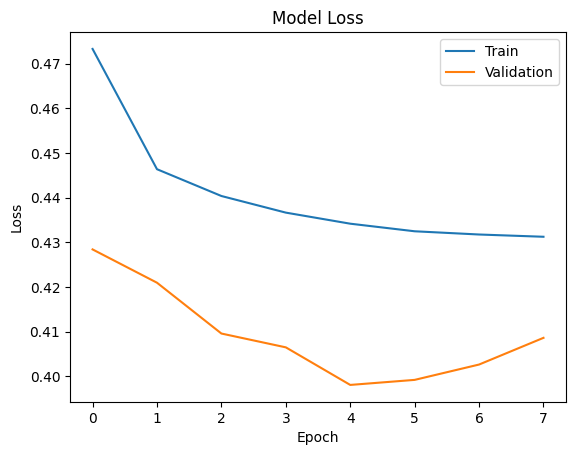

In [164]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [165]:
predictions_both = model.predict(X_test)
predictions_both[:10]

6249/6249 [==============================] - 4s 567us/step


array([[8.4091651e-01],
       [7.8510404e-01],
       [6.6901284e-01],
       [6.0143799e-01],
       [4.6150842e-07],
       [1.2483450e-02],
       [9.9843150e-01],
       [3.0932450e-01],
       [8.5901438e-06],
       [9.9405503e-01]], dtype=float32)

In [166]:
predictions_background = model.predict(X_test1)
predictions_background[:10]

2535/2535 [==============================] - 2s 600us/step


array([[1.3697536e-01],
       [5.5976725e-01],
       [9.5530838e-02],
       [4.2423898e-01],
       [5.8002877e-03],
       [5.1200697e-03],
       [1.0717433e-02],
       [1.4557719e-02],
       [3.7369803e-14],
       [9.4110094e-02]], dtype=float32)

In [167]:
predictions_signal = model.predict(X_test2)
predictions_signal[:10]

3714/3714 [==============================] - 2s 564us/step


array([[0.84546214],
       [0.8868382 ],
       [0.7900574 ],
       [0.8442955 ],
       [0.7844225 ],
       [0.9957984 ],
       [0.91132253],
       [0.7116033 ],
       [0.6369818 ],
       [0.7828495 ]], dtype=float32)

In [168]:
#predict accuract given y_test and predictions from model
def pred_accuracy(y_test, predictions):
    D_count, Lambda_count = 0, 0

    predictions_list = []
    for pred in predictions:
        #arbitrary cutoff of 0.5
        if float(pred) > 0.5:
            predictions_list.append(int(1))
            Lambda_count+=1
        elif float(pred) < 0.5:
            predictions_list.append(int(0))
            D_count+=1
            
    accuracy = np.mean(predictions_list == y_test)
    
    # print("$D^+$ Count: {}".format(D_count))
    # print("$\Lambda_C^+ Count: {}".format(Lambda_count))
    
    return accuracy

accuracy_both = pred_accuracy(y_test, list(predictions_both))
accuracy_background = pred_accuracy(y_test1, list(predictions_background))
accuracy_signal = pred_accuracy(y_test2, list(predictions_signal))

print("Accuracy for Both: {:.2%}".format(accuracy_both))
print("Accuracy for Only Background: {:.2%}".format(accuracy_background))
print("Accuracy for Only Signal: {:.2%}".format(accuracy_signal))

Accuracy for Both: 84.32%
Accuracy for Only Background: 70.72%
Accuracy for Only Signal: 93.70%


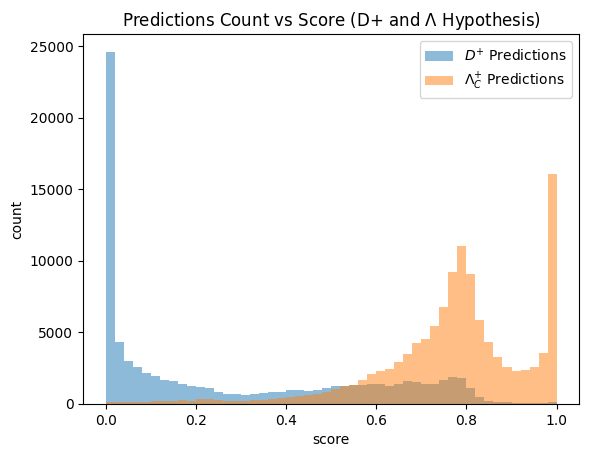

In [172]:
hist = plt.hist(predictions_background, bins = 50, label = "$D^{+}$ Predictions", alpha=0.5)
hist2 = plt.hist(predictions_signal, bins = 50, label = "$\Lambda_C^{+}$ Predictions", alpha=0.5)
plt.xlabel("score")
plt.ylabel("count")
plt.title("Predictions Count vs Score (D+ and $\Lambda$ Hypothesis)")
plt.legend()
plt.show()

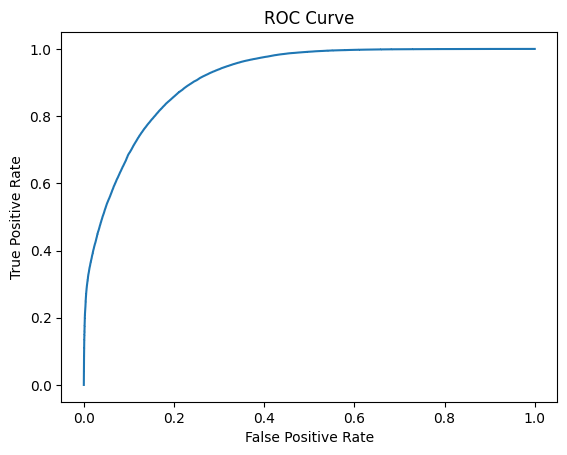

In [170]:
# Get true labels and predicted probabilities
y_true = list(y_test)
y_pred = predictions_both

# Calculate TPR and FPR for different threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()